In [1]:
#-- YOLO World and DINO --

In [2]:
#-- Install ultralytics for YOLO World --------------------------------------------------------------------------
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
#---------------------------------------------------------------------------------------------------------------

Ultralytics YOLOv8.2.17 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.6/8062.4 GB disk)


In [3]:
#-- Install GroundingDINO  ----------------------------------------------------------------------------------------
%cd /kaggle/working/  

!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd GroundingDINO/
!pip install -e .

!mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth

%cd /kaggle/working/GroundingDINO    

#-- clear output --
from IPython import display
display.clear_output()  

!python -c "import groundingdino" && echo "Module installed successfully" || echo "Module installation failed"
#---------------------------------------------------------------------------------------------------------------

Module installed successfully


In [4]:
#-- Import -----------------------------------------------------------------------------------------------
%cd /kaggle/working/GroundingDINO
from groundingdino.util.inference import load_model as dn_load_model
from groundingdino.util.inference import load_image as dn_load_image
from groundingdino.util.inference import predict as dn_predict
from groundingdino.util.inference import annotate as dn_annotate
%cd /kaggle/working

from ultralytics import YOLO

import torch

import os
import shutil

import PIL
import cv2

import matplotlib.pyplot as plt

import random
#---------------------------------------------------------------------------------------------------------------

/kaggle/working/GroundingDINO
/kaggle/working


In [5]:
#-- Initialize ---------------------------------------------------------------------------------------------------
out_path = '/kaggle/working/'
images_dir = '/kaggle/input/zsod-test-images/'
lbls_file = '/kaggle/input/all-labels/all_labels.txt'

dino_model_config_file = out_path + 'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
dino_model_weights_file = out_path + 'GroundingDINO/weights/groundingdino_swint_ogc.pth'

dino_results = out_path + 'dino_results/'

YOLO_CONF_THRESHOLD = 0.1
YOLO_IOU_THRESHOLD = 0.5

DINO_BOX_THRESHOLD = 0.25
DINO_TEXT_THRESHOLD = 0.1

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:' , DEVICE)
#-----------------------------------------------------------------------------------------------------------------

device: cuda


In [6]:
#-- lLad all labels -----------------------------------------------------------------------------------------------
all_labels = set()
with open(lbls_file, "r") as file:
    for line in file:            
        lbl = line.strip().lower()
        all_labels.add(lbl)   

print('number of all labels:' , len(all_labels))

yolo_all_labels = list(all_labels)

dino_all_labels = ''
for lbl in all_labels:
    dino_all_labels += lbl + ' . '
#-----------------------------------------------------------------------------------------------------------------

number of all labels: 1873


In [7]:
#-- Run YOLO-World  ---------------------------------------------------------------------------------------------------

#-- Create Model --
model = YOLO('yolov8x-worldv2.pt')
display.clear_output()

#-- Set Custome Classes --
model.set_classes(yolo_all_labels)

#-- Run Model to Predict Objects --
project_value = 'yolo_world_results'
name_value = 'predictions'        
model.predict(source = images_dir,
              conf = YOLO_CONF_THRESHOLD,
              iou = YOLO_IOU_THRESHOLD,
              show = False,
              save= True,
              project= project_value,
              name=name_value) 
        
display.clear_output()
print('Finished Predicting :)')
#-----------------------------------------------------------------------------------------------------------------

Finished Predicting :)


In [8]:
#-- Plot BBoxes for DINO ----------------------------------------------------------------------------------------
def plot_boxes(image, boxes, logits, phrases):
    
    annotated_img = dn_annotate(image_source=image,
                                    boxes=boxes,
                                    logits=logits,
                                    phrases=phrases)
        
    out_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)        
    plt.imshow(out_img, interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])        
    plt.show()  
    
    return out_img
#-----------------------------------------------------------------------------------------------------------------

In [9]:
#-- Run DINO -----------------------------------------------------------------------------------------------------
#-- Create Model --
model_dino = dn_load_model(dino_model_config_file,
                           dino_model_weights_file,
                           device= DEVICE)

#-- create dino_results folder --
os.makedirs(dino_results, exist_ok=True)

#-- load images --
image_files = [f for f in os.listdir(images_dir)]  

#-- Run DINO on all images --
for img_file in image_files:     
    
    #-- load image --
    image_source, image = dn_load_image(images_dir+img_file)
    
    #-- predict on images --
    boxes, logits, phrases = dn_predict(model = model_dino,
                                        image = image,
                                        caption = dino_all_labels,
                                        box_threshold = DINO_BOX_THRESHOLD,
                                        text_threshold = DINO_TEXT_THRESHOLD)
    #-- annotate image with bbox --
    annotated_img = dn_annotate(image_source=image_source,
                                boxes=boxes,
                                logits=logits,
                                phrases=phrases)
        
    #-- save result --
    result_img = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)     
    cv2.imwrite(dino_results + img_file, result_img)

display.clear_output()
print('Finished Predicting :)')
#-----------------------------------------------------------------------------------------------------------------

Finished Predicting :)


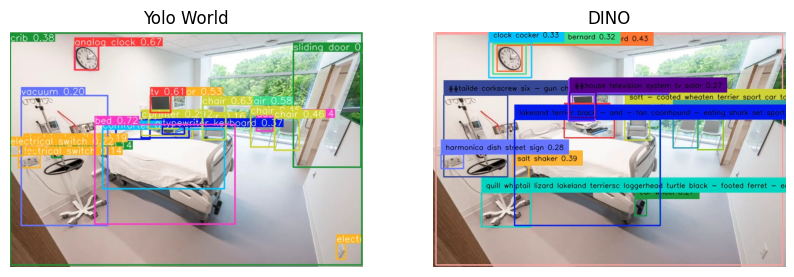

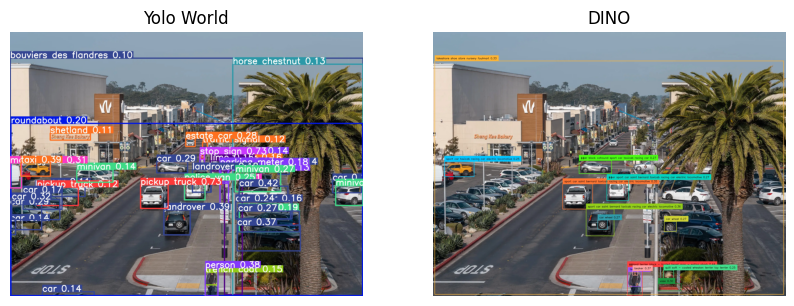

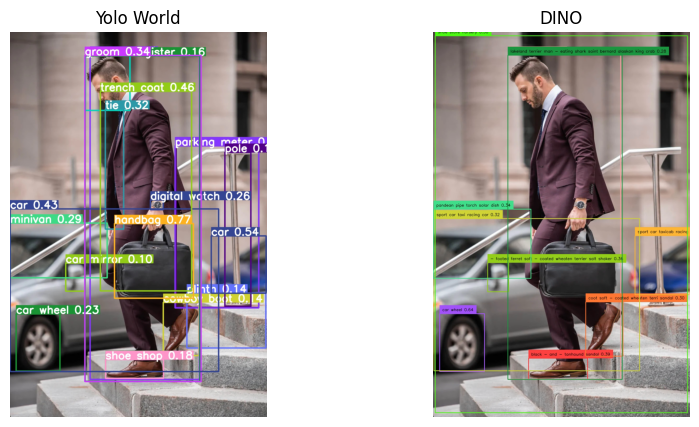

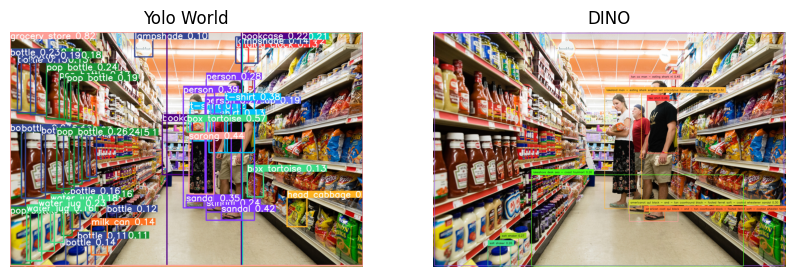

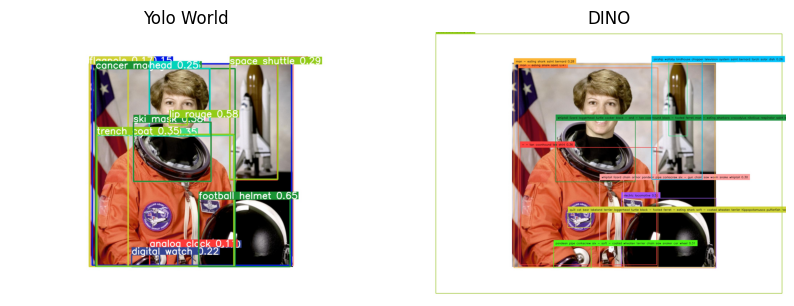

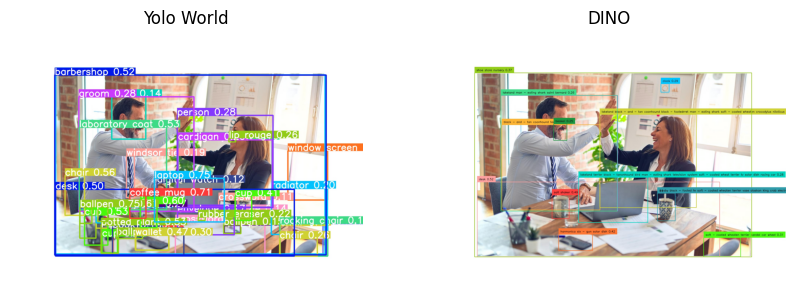

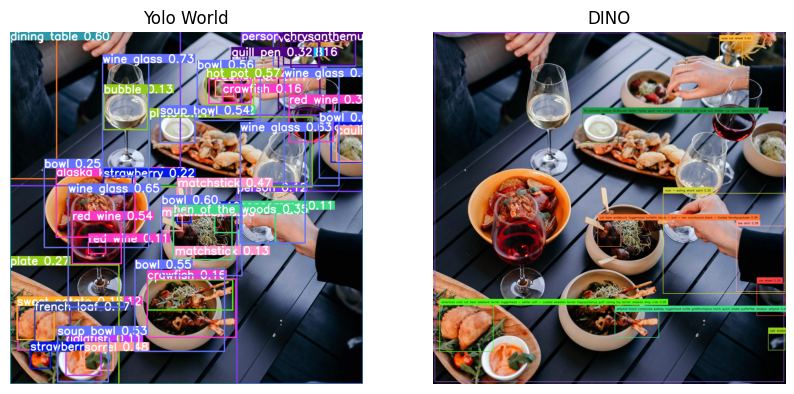

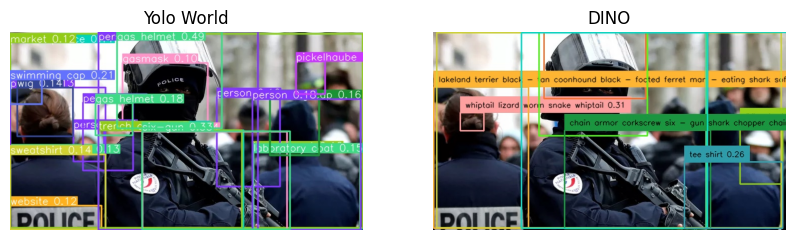

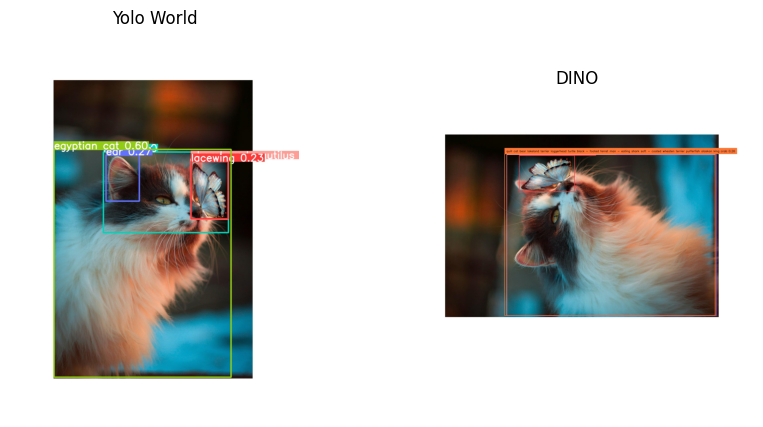

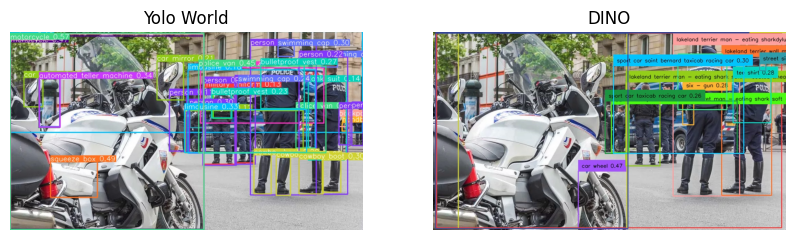

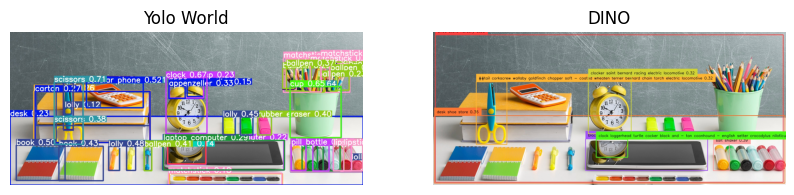

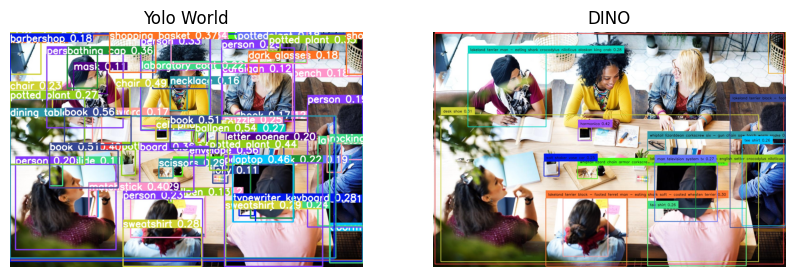

In [10]:
#-- Plot and Compare Results --------------------------------------------------------------------------------------
yolo_results_dir = '/kaggle/working/yolo_world_results/predictions/'
dino_results_dir = '/kaggle/working/dino_results/'

result_image_files = [f for f in os.listdir(yolo_results_dir)]  

for img_file in result_image_files:    
    
    img_yolo = cv2.imread(yolo_results_dir + img_file)
    img_yolo = cv2.cvtColor(img_yolo, cv2.COLOR_BGR2RGB)     
    img_dino = cv2.imread(dino_results_dir + img_file)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
       
    axs[0].imshow(img_yolo)
    axs[0].set_title('Yolo World')
    axs[0].axis('off')
       
    axs[1].imshow(img_dino)
    axs[1].set_title('DINO')
    axs[1].axis('off')
       
    plt.show()

